In [1]:
import sys
sys.path.append('../')
from asap.util.io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
from asap.data.dataloader import DataSet
from asap.util import topics
from asap.factorize import ASAPNMF
import asapc
import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc
from sklearn.preprocessing import StandardScaler
# import logging


experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

sample_in = args.home + args.experiment + args.input+ args.sample_id +'/'+args.sample_id
sample_out = args.home + args.experiment + args.output+ args.sample_id +'/'+args.sample_id



tree_max_depth = 10
num_factors = 10
batch_size = 10000
batch_iteration = 1
downsample_pseudobulk = True
downsample_size = 100

dl = DataSet(sample_in,sample_out)
sample_list = dl.get_dataset_names()
dl.initialize_data(sample_list,batch_size)




print(dl.inpath)
print(dl.outpath)


/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/tabula_sapiens/tabula_sapiens
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/tabula_sapiens/tabula_sapiens


In [2]:
model = np.load(sample_out+'_10000_dcnmf.npz')

In [3]:
df_beta = pd.DataFrame(model['beta'].T)
df_beta.columns = dl.genes
df_theta = pd.DataFrame(model['corr'])
df_theta.index = model['barcodes']

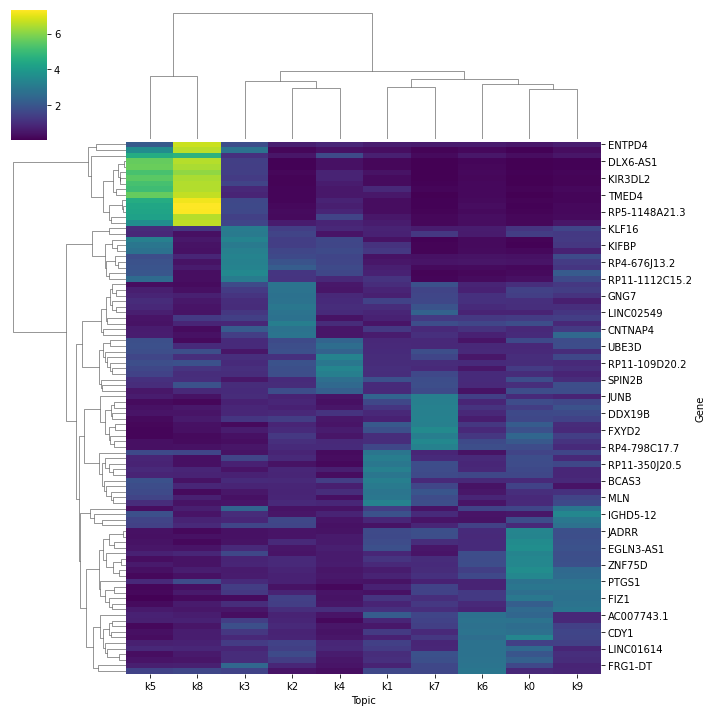

In [4]:
df_top = topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=10)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
# df_top[df_top>20] = 20
sns.clustermap(df_top.T,cmap='viridis')

In [5]:
import umap
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df_umap= pd.DataFrame()
df_umap['cell'] = model['barcodes']
# df_umap['topic_bulk'] = [x for x in df_theta.iloc[:,:].idxmax(axis=1)]

scaler = StandardScaler()
scaled = scaler.fit_transform(df_theta.to_numpy())
kmeans = KMeans(n_clusters=10, init='k-means++',random_state=0).fit(scaled)
df_umap['topic_bulk'] = kmeans.labels_

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.0,metric='cosine')
proj_2d = umap_2d.fit(df_theta.iloc[:,1:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap

# df_umap = pd.read_csv(sample_out+'_theta_umap.csv')
# df_umap.columns = ['cell','umap1','umap2']


,cell,topic_bulk,umap1,umap2
0,hbca_n01_AAACCTGAGAATAGGG-1@bc_117k,4,1.897972,4.676794
1,hbca_n01_AAACCTGCAGAGCCAA-1@bc_117k,6,16.943758,0.341269
2,hbca_n01_AAACCTGCAGCTCGAC-1@bc_117k,4,1.757139,4.609047
3,hbca_n01_AAACCTGTCAAGAAGT-1@bc_117k,6,16.491240,0.162748
4,hbca_n01_AAACCTGTCGCGCCAA-1@bc_117k,4,0.999349,4.560424
...,...,...,...,...
9994,CAGAGCCAGCAATTCC_TSP7_Blood_NA_10X_1_1@immune_...,4,1.156466,3.301285
9995,CAGAGCCCAAATCAAG_TSP7_Blood_NA_10X_1_1@immune_...,5,5.748389,1.539410
9996,CAGAGCCCAAGCCCAC_TSP7_Blood_NA_10X_1_1@immune_...,2,-2.227850,13.610886
9997,CAGAGCCCAGTTCTAG_TSP7_Blood_NA_10X_1_1@immune_...,2,-3.092866,13.542749


Text(0, 0.5, 'UMAP2')

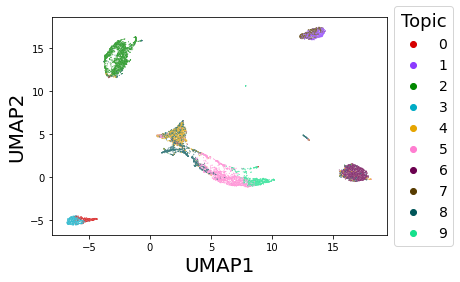

In [7]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_bulk'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_bulk',s=1,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
# p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

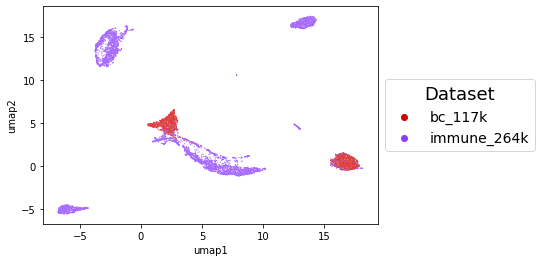

In [83]:
# df_umap['batch'] = [x.split('@')[1]for x in df_umap['cell']]
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['batch'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='batch',s=1,palette=cp,legend=True)
plt.legend(title='Dataset',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))

In [71]:
import h5py as hf
inpath = '/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/tabula_sapiens/'
cell_type = []
for ds in dl.dataset_list:
    
    f = hf.File(inpath+ds+'.h5ad','r')
    cell_ids = [x.decode('utf-8') for x in f['obs']['_index']]
    codes = list(f['obs']['cell_type']['codes'])
    cat = [x.decode('utf-8') for x in f['obs']['cell_type']['categories']]
    f.close()
    
    catd ={}
    for ind,itm in enumerate(cat):catd[ind]=itm
    
    cell_type = cell_type + [ [x,catd[y]] for x,y in zip(cell_ids,codes)]

In [74]:
df_ct = pd.DataFrame(cell_type)
df_ct.columns = ['cell','cell_type']
df_ct

,cell,cell_type
0,hbca_n01_AAACCTGAGAATAGGG-1,endothelial cell of lymphatic vessel
1,hbca_n01_AAACCTGCAGAGCCAA-1,adipocyte of breast
2,hbca_n01_AAACCTGCAGCTCGAC-1,endothelial cell of vascular tree
3,hbca_n01_AAACCTGTCAAGAAGT-1,adipocyte of breast
4,hbca_n01_AAACCTGTCGCGCCAA-1,myeloid cell
...,...,...
382165,TSP2_Vasculature_aorta_SS2_B113343_B133091_Imm...,macrophage
382166,TSP2_Vasculature_aorta_SS2_B113343_B133091_Imm...,macrophage
382167,TSP2_Vasculature_aorta_SS2_B113343_B133091_Imm...,macrophage
382168,TSP2_Vasculature_aorta_SS2_B113343_B133091_Imm...,macrophage


In [77]:
df_umap['cell'] = [x.split('@')[0] for x in df_umap['cell']]
df_umap = pd.merge(df_umap,df_ct[['cell','cell_type']],on='cell',how='left')
df_umap

,cell,topic_bulk,umap1,umap2,batch,cell_type
0,hbca_n01_AAACCTGAGAATAGGG-1,4,1.897972,4.676794,bc_117k,endothelial cell of lymphatic vessel
1,hbca_n01_AAACCTGCAGAGCCAA-1,6,16.943758,0.341269,bc_117k,adipocyte of breast
2,hbca_n01_AAACCTGCAGCTCGAC-1,4,1.757139,4.609047,bc_117k,endothelial cell of vascular tree
3,hbca_n01_AAACCTGTCAAGAAGT-1,6,16.491240,0.162748,bc_117k,adipocyte of breast
4,hbca_n01_AAACCTGTCGCGCCAA-1,4,0.999349,4.560424,bc_117k,myeloid cell
...,...,...,...,...,...,...
9994,CAGAGCCAGCAATTCC_TSP7_Blood_NA_10X_1_1,4,1.156466,3.301285,immune_264k,classical monocyte
9995,CAGAGCCCAAATCAAG_TSP7_Blood_NA_10X_1_1,5,5.748389,1.539410,immune_264k,classical monocyte
9996,CAGAGCCCAAGCCCAC_TSP7_Blood_NA_10X_1_1,2,-2.227850,13.610886,immune_264k,"CD8-positive, alpha-beta cytokine secreting ef..."
9997,CAGAGCCCAGTTCTAG_TSP7_Blood_NA_10X_1_1,2,-3.092866,13.542749,immune_264k,naive B cell


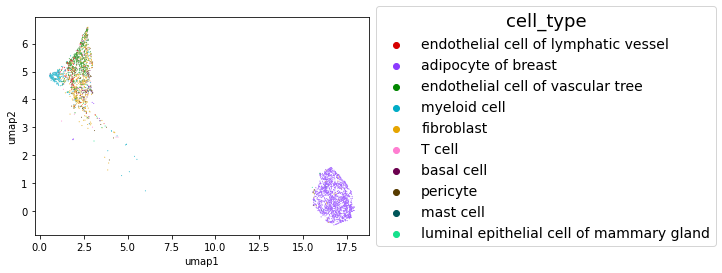

In [92]:
df_umap2 = df_umap.loc[df_umap['batch']=='bc_117k',:]
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap2['cell_type'].unique()))
p = sns.scatterplot(data=df_umap2, x='umap1', y='umap2', hue='cell_type',s=1,palette=cp,legend=True)
plt.legend(title='cell_type',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))

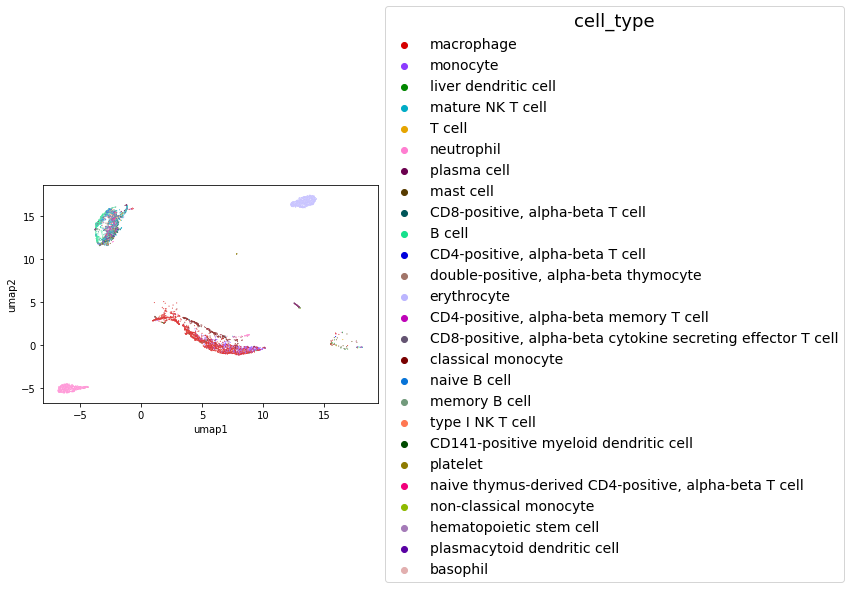

In [91]:
df_umap2 = df_umap.loc[df_umap['batch']=='immune_264k',:]
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap2['cell_type'].unique()))
p = sns.scatterplot(data=df_umap2, x='umap1', y='umap2', hue='cell_type',s=1,palette=cp,legend=True)
plt.legend(title='cell_type',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))

In [88]:
df_match = df_umap[['cell','cell_type','topic_bulk']]
df_match = df_match.groupby(['cell_type','topic_bulk']).count().reset_index()
df_match = df_match.pivot('cell_type','topic_bulk')
df_match = df_match.fillna(0)
df_match

cell                \
topic_bulk                                              0      1      2   
cell_type                                                                 
B cell                                                0.0    0.0  423.0   
CD141-positive myeloid dendritic cell                 0.0    0.0    2.0   
CD4-positive, alpha-beta T cell                       0.0    0.0   56.0   
CD4-positive, alpha-beta memory T cell                0.0    0.0   86.0   
CD8-positive, alpha-beta T cell                       0.0    0.0  462.0   
CD8-positive, alpha-beta cytokine secreting eff...    0.0    0.0  147.0   
T cell                                                0.0    0.0  123.0   
adipocyte of breast                                   0.0    0.0    0.0   
basal cell                                            0.0    0.0    0.0   
basophil                                              0.0    0.0    2.0   
classical monocyte                                    1.0    0.0    1.0   
double-positive, alpha-beta thymocyte                 0.0    0.0    5.0   
endothelial cell of lymphatic vessel                  0.0    0.0    0.0   
endothelial cell of vascular tree                     0.0    0.0    0.0   
erythrocyte                                           0.0  545.0    0.0   
fibroblast                                            0.0    0.0    0.0   
hematopoietic stem cell                               0.0    0.0    4.0   
liver dendritic cell                                  0.0    0.0    1.0   
luminal epithelial cell of mammary gland              0.0    0.0    0.0   
macrophage                                            3.0    0.0    4.0   
mast cell                                             0.0    0.0    1.0   
mature NK T cell                                      0.0    0.0  392.0   
memory B cell                                         0.0    0.0   28.0   
monocyte                                              0.0    0.0    5.0   
myeloid cell                                          0.0    0.0    0.0   
naive B cell                                          0.0    0.0   79.0   
naive thymus-derived CD4-positive, alpha-beta T...    0.0    0.0   36.0   
neutrophil                                          280.0    0.0    1.0   
non-classical monocyte                                0.0    0.0    0.0   
pericyte                                              0.0    0.0    0.0   
plasma cell                                           0.0    0.0   35.0   
plasmacytoid dendritic cell                           0.0    0.0    1.0   
platelet                                              0.0    0.0    1.0   
type I NK T cell                                      0.0    0.0   53.0   

                                                                         \
topic_bulk                                              3      4      5   
cell_type                                                                 
B cell                                                0.0   25.0    2.0   
CD141-positive myeloid dendritic cell                 0.0    0.0    0.0   
CD4-positive, alpha-beta T cell                       0.0    4.0    0.0   
CD4-positive, alpha-beta memory T cell                0.0    4.0    1.0   
CD8-positive, alpha-beta T cell                       0.0    6.0    0.0   
CD8-positive, alpha-beta cytokine secreting eff...    0.0    3.0    2.0   
T cell                                                0.0   10.0    3.0   
adipocyte of breast                                   0.0   48.0    0.0   
basal cell                                            0.0   11.0    4.0   
basophil                                              0.0    0.0    0.0   
classical monocyte                                    0.0   20.0  218.0   
double-positive, alpha-beta thymocyte                 0.0    1.0    0.0   
endothelial cell of lymphatic vessel                  0.0   36.0    0.0   
endothelial cell of vascular tree                     0.0  278.0    5.0   
er

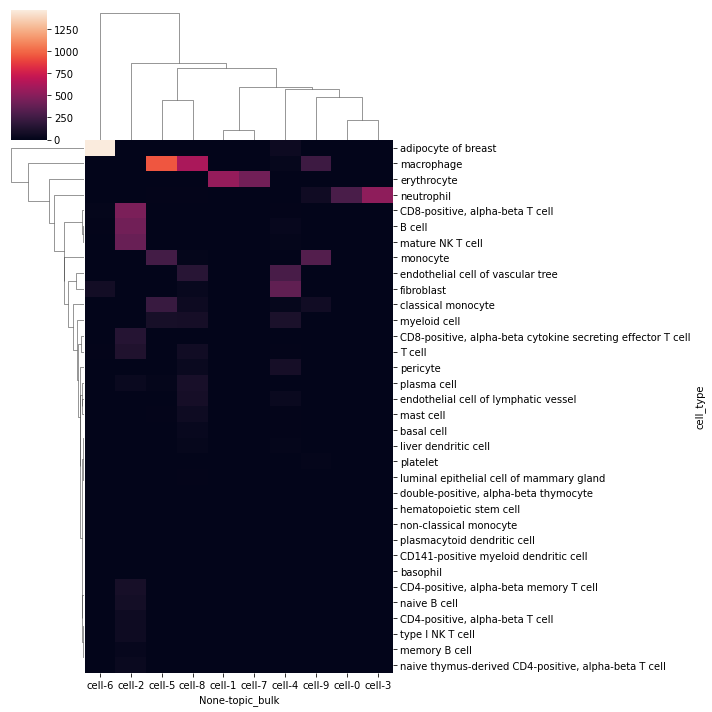

In [89]:
sns.clustermap(df_match)

In [90]:
from sklearn.metrics import normalized_mutual_info_score

normalized_mutual_info_score(df_umap['cell_type'].values,df_umap['topic_bulk'].values)

0.6049068534097356